In [1]:
import numpy as np 
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import minimum_spanning_tree
from skimage import io
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque
from sklearn.neighbors import KDTree
import skimage.io as skio
import pandas as pd
import scipy.io as sio
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO

In [4]:
def open_file(file, RGBW_channels):

    img = io.imread(file) # should open as C, Z, Y, X 
    img = np.transpose(img)

    img = img[:,:,:,RGBW_channels]

    return img



In [5]:
im = open_file('/Users/danielysprague/foco_lab/data/NP_FOCO_cropped/2022-04-01-w00-NP1/neuropal_1_MMStack_Pos0.ome.tif', [0,2,4,1])


In [4]:
def get_w(im):
    '''
    get pixels in image with pixel intensity values >1SD above the mean of the pixel intensity values 
    in the image
    Input: image to derive w from (should be 3D volume)
    Output: Nx4 array where N is the number of pixels with intensity >1SD above the mean. Each element
    in array has (X, Y, Z, intensity) values corresponding to the location of the pixel in the image and its 
    intensity
    '''

    imsum = np.sum(im, axis=3) # use superimposition of values across color channels   

    mean = np.mean(imsum, axis = (0,1,2))
    std = np.std(imsum, axis = (0,1,2))

    thresh = mean+std

    W = np.argwhere(imsum>=thresh)

    I = np.zeros((len(W),1))
    for i, p in enumerate(W):
        I[i] = imsum[p[0],p[1],p[2]]

    W = np.hstack((W,I))

    W_remove_sparse = np.zeros(W.shape)

    for i, p in enumerate(W): 
        #Remove any points from W that are on the edge of the image or do not neighbor any other points in W to remove unwanted random background points
        x = int(p[0])
        y = int(p[1])
        z = int(p[2])
        intens = int(p[3])

        if x == 0 or x == imsum.shape[0]-1 or y == 0 or y == imsum.shape[1]-1 or z ==0 or z ==imsum.shape[2]-1:
            pass

        elif not np.any(np.where(imsum[x-1:x+1,y-1:y+1,z-1:z+1]<thresh)):
           W_remove_sparse[i] = np.asarray([x,y,z,intens])

    W_remove_sparse = W_remove_sparse[~np.all(W_remove_sparse==0, axis=1)]    

    plt.figure(figsize=(20,12))
    plt.scatter(W_remove_sparse[:,0], W_remove_sparse[:,1], s=1)
    plt.gca().set_aspect('equal')
    plt.show()

    return W_remove_sparse

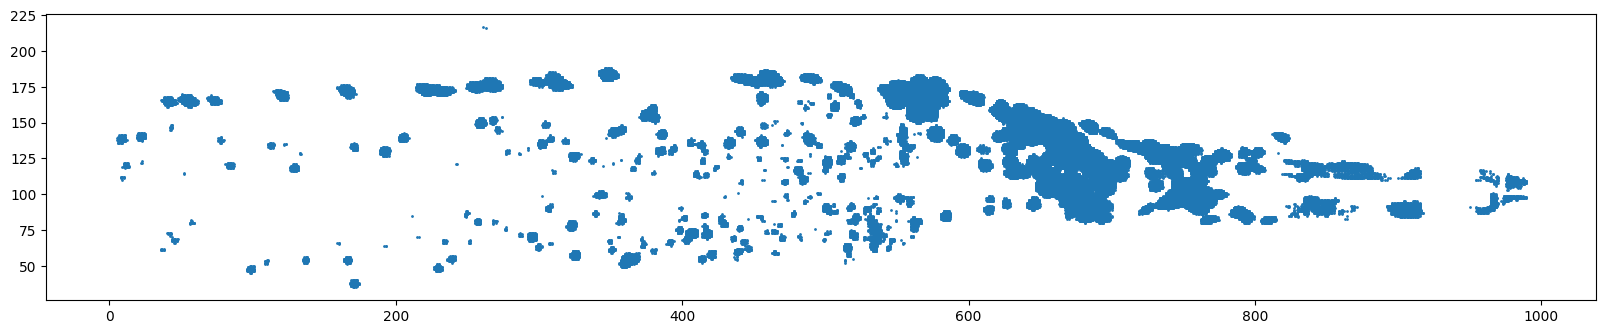

In [5]:
W = get_w(im)

In [87]:
def init_control(W, num_points, first_control=None):
    '''
    Initialize random control points. Sample num_points from w randomly to use as initial control
    points and define the graph w/ edges as distances between control points.
    Input: 
    W - list of pixels in image with intensity >1SD above the mean of the image, 
    num_points - number of control points to sample from the image
    first_control - optional parameter for setting a user defined initial control point. ie the tip
    of the nose of the animal 
    Output: 
    num_points x num_points array representing the graph with initial control points as 
    vertices and edges as the euclidean distances between each vertex 
    Control - num_points x 3 unordered list of control poitns
    '''

    control = np.zeros((num_points,3))

    if first_control is not None:
        control[0] = first_control
        num_points=num_points-1

        control[1:] = W[np.random.choice(W.shape[0], size=num_points, replace=False),:-1]
    
    else:
        control = W[np.random.choice(W.shape[0], size=num_points, replace=False),:-1]

    graph = cdist(control, control, 'euclidean') # calculate pairwise euclidean distances

    plt.figure(figsize=(20,12))
    plt.scatter(control[:,0], control[:,1], s=10)
    plt.gca().set_aspect('equal')
    plt.show()

    return graph, control

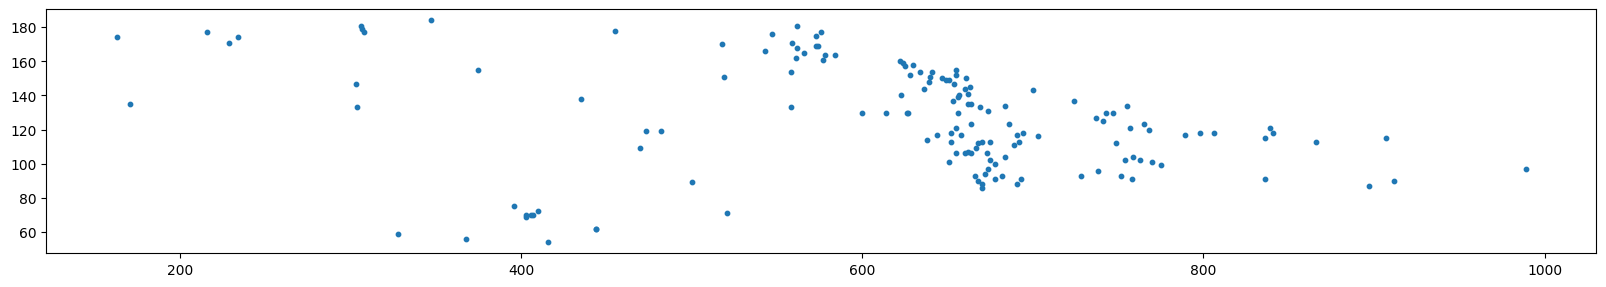

In [88]:
graph, control = init_control(W, 150)

In [89]:
print(graph)

[[  0.         283.1148177  212.6828625  ... 140.03570973 182.54040649
  100.8265838 ]
 [283.1148177    0.         493.88055236 ... 168.75425921 431.8645621
  198.20696254]
 [212.6828625  493.88055236   0.         ... 337.55295881 129.69579793
  299.67649224]
 ...
 [140.03570973 168.75425921 337.55295881 ...   0.         263.75936002
   46.17358552]
 [182.54040649 431.8645621  129.69579793 ... 263.75936002   0.
  237.05906437]
 [100.8265838  198.20696254 299.67649224 ...  46.17358552 237.05906437
    0.        ]]


In [90]:
def get_initial_path(graph, control):
    '''
    Calculate minimum spanning tree of graph of edges between vertices and then identify longest path
    to get through the minimum spanning tree. This path will define the initial ordering of the control points.
    Control points that are not part of this longest path will be removed from the graph
    Input:
    NxN array representing graph with initial control points as vertices and edges as distnaces between vertices
    Output:
    Nx3 array with ordered initial control points
    '''

    mst = np.zeros_like(graph)

    visited = set([0])

    for i in range(len(control-1)):

        edges = [(j,k) for j in visited for k in range(len(control)) if k not in visited]
        
        if len(edges)==0:
            continue

        jprev, knext = edges[np.argmin([graph[j,k] for (j, k) in edges])]

        visited.add(knext)
        mst[jprev,knext] = graph[jprev,knext]
        mst[knext,jprev] = graph[knext,jprev]

    def dfs(node, parent, mst, path_lengths):

        for i, weight in enumerate(mst[node]):
            if i != parent and weight > 0:
                path_lengths[i] = path_lengths[node] + weight
                dfs(i, node, mst, path_lengths)
        return path_lengths

    rand_node = 0
    path_lengths = np.zeros(len(control))
    path_lengths = dfs(rand_node, -1, mst, path_lengths)
    start_node = np.argmax(path_lengths)

    print('first pass done')

    second_path_lengths = np.zeros(len(control))

    second_path_lengths = dfs(start_node, -1, mst, second_path_lengths)
    end_node = np.argmax(second_path_lengths)

    print(second_path_lengths[end_node])

    longest_path = [end_node]

    print('second pass done')

    print(control[start_node])
    print(control[end_node])
    print(start_node)

    def dfs_path(graph, start, end, visited=None, path=None):
        if visited is None:
            visited = []

        if path is None:
            path = []

        visited.append(start)

        if start==end:
            return path +[start]

        for i, weight in enumerate(graph[start]):
            if i not in visited and weight>0:
                new_path = dfs_path(graph, i, end, visited, path+[start])
                if new_path:
                    return new_path
                
        return None
        

    path = [end_node]
    longest_path = dfs_path(mst, start_node, end_node, visited = None, path=None)
    print(end_node)
    print(longest_path)

    #while parent != start_node:
    #    parent = np.argmax([mst[parent,i] for i in range(len(control)) if i not in longest_path])
    #    longest_path.append(parent)

    ordered_control = control[longest_path[::-1]]

    
    return ordered_control, mst

first pass done
1026.4494347825485
second pass done
[989.  97.  24.]
[171. 135.  11.]
135
57
[135, 28, 116, 121, 136, 1, 73, 54, 69, 18, 89, 81, 118, 91, 102, 26, 15, 70, 98, 84, 124, 3, 74, 109, 114, 140, 63, 68, 36, 138, 115, 131, 137, 65, 87, 106, 145, 0, 66, 49, 56, 23, 72, 33, 58, 2, 117, 29, 5, 143, 134, 11, 57]


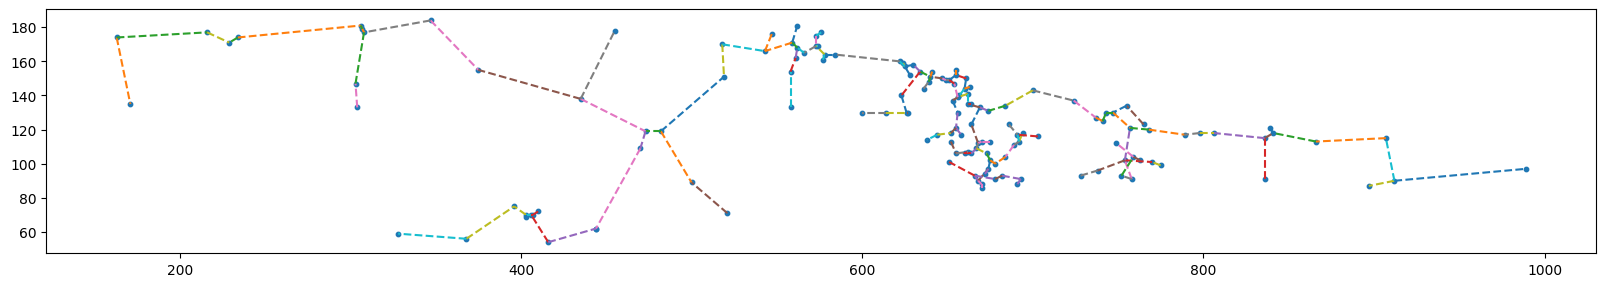

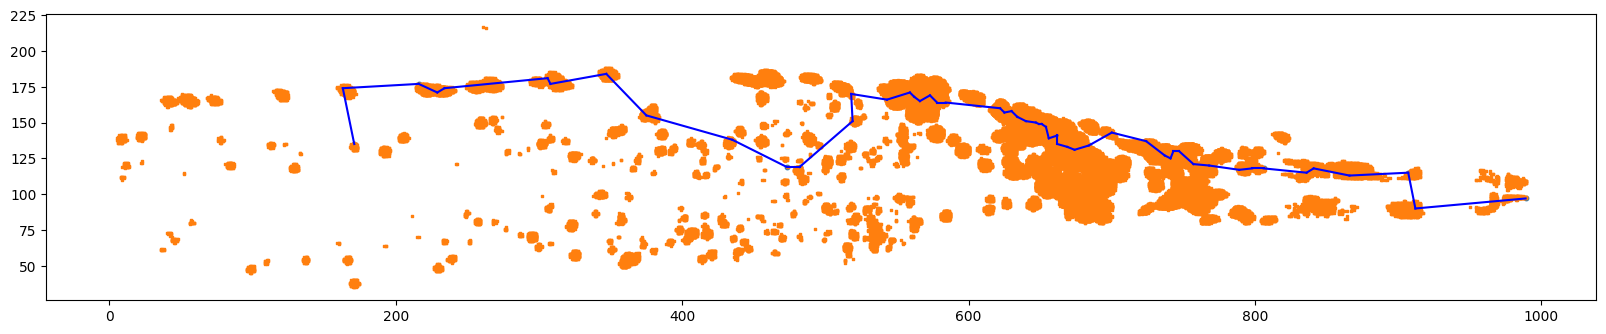

In [91]:
ordered_control, mst = get_initial_path(graph, control)

plt.figure(figsize=(20,12))
plt.scatter(control[:,0], control[:,1], s=10)
for i in range(len(control)):
    for j in range(i,len(control)):
        if mst[i,j] !=0:
            plt.plot([control[i,0],control[j,0]], [control[i,1], control[j,1]], linestyle="--")
plt.gca().set_aspect('equal')
plt.show()

plt.figure(figsize=(20,12))
plt.scatter(ordered_control[:,0], ordered_control[:,1], s=10)
plt.scatter(W[:,0], W[:,1], s=1, marker=',')
for i in range(1,len(ordered_control)):
    plt.plot([ordered_control[i-1,0],ordered_control[i,0]], [ordered_control[i-1,1], ordered_control[i,1]], linestyle="-", color='blue')
plt.gca().set_aspect('equal')
plt.show()

In [92]:
print(mst[137])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          6.08276253
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

In [93]:
def calc_voronoi_region(W, control):
    tree = KDTree(control)

    dist, index = tree.query(W[:,:-1], dualtree=True) 

    voronoi = {i: (W[np.where(index==i)[0],:], dist[np.where(index==i)[0]]) for i in range(len(control))} # get index of each pixel in W in voronoi region of each control point i

    plt.figure(figsize=(20,12))

    for c, (vals,dist) in voronoi.items():
        plt.scatter(vals[:,0],vals[:,1], s=1)

    plt.scatter(control[:,0], control[:,1], s=10)
    for i in range(1,len(control)):
        plt.plot([control[i-1,0],control[i,0]], [control[i-1,1], control[i,1]], linestyle="-", color='blue')
    plt.gca().set_aspect('equal')   
    plt.show()

    return voronoi




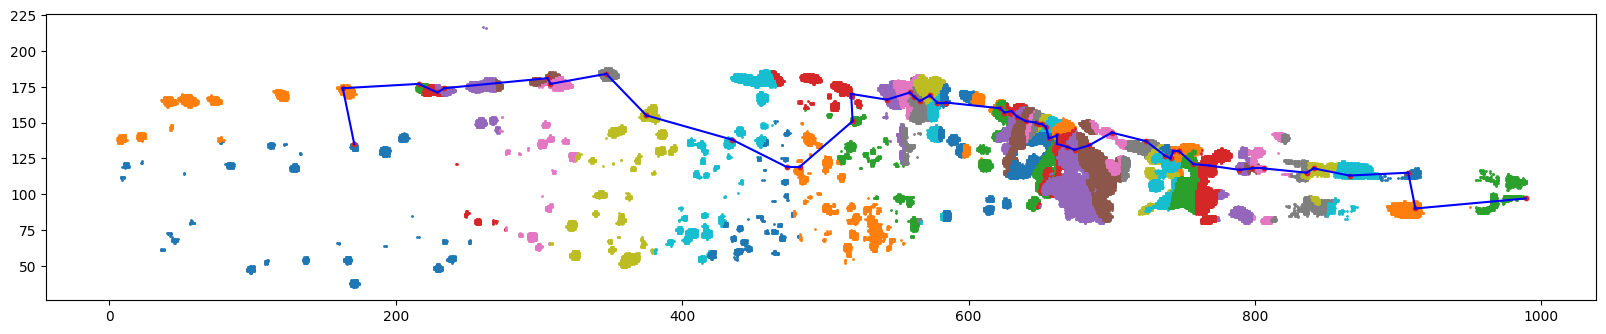

In [94]:
voronoi = calc_voronoi_region(W,ordered_control)

In [95]:
print(voronoi.keys())

print(ordered_control.shape)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52])
(53, 3)


In [105]:
def update_control_points(control, voronoi, alpha = 0.5, beta = 0.25, gamma = 0.33):

    '''
    Update control points by minimizing partial derivatives of energy function with respect 
    to each of the control points. Repeat until control points stop moving
    Input:
    Nx3 array with ordered list of initial control points
    W - points in 
    Output:
    Nx3
    '''

    new_control = np.zeros(control.shape)

    for k in range(control.shape[0]):

        Eimage = 2*alpha*np.average(np.asarray([p[0:3] for p in voronoi[k][0]]),axis=0)

        divalph = 2*alpha

        if k ==0:
            Elen = 2*beta*control[k+1]
            divbeta = 2*beta
            Esmooth = gamma*(control[k+1]-0.5*control[k+2])
            divgamma = 0.5*gamma

        elif k==1:
            Elen = 2*beta*(control[k-1]+control[k+1])
            divbeta = 4*beta

            Esmooth = gamma*(control[k-1]+2*control[k+1]-0.5*control[k+2])
            divgamma = 2.5*gamma

        elif k == control.shape[0]-2:
            Elen = 2*beta*(control[k-1]+control[k+1])
            divbeta = 4*beta

            Esmooth = gamma*(control[k+1]+2*control[k-1]-0.5*control[k-2])
            divgamma = 2.5*gamma

        elif k == control.shape[0]-1:
            Elen = 2*beta*control[k-1]
            divbeta = 2*beta
            Esmooth = gamma*(control[k-1]-0.5*control[k-2])
            divgamma = 0.5*gamma

        else:
            Elen = 2*beta*(control[k-1]+control[k+1])

            divbeta = 4*beta

            Esmooth = gamma*(2*control[k-1]+2*control[k+1]-0.5*control[k-2]+0.5*control[k+2])

            divgamma = 3*gamma

        if np.any(np.isnan(Eimage)): #there are no pixels in W in voronoi region of control point
            new_control[k, :] = np.asarray([0,0,0])

        else:
            new_control[k,:] = (Eimage +Elen+ Esmooth) / (divalph+divbeta+divgamma)

    control = control[~np.all(new_control==0, axis=1)]
    new_control = new_control[~np.all(new_control==0, axis=1)]

    difference = np.average([np.linalg.norm(new_control[i]-control[i]) for i in range(control.shape[0])])

    return new_control, difference

In [106]:
new_control, difference = update_control_points(ordered_control, voronoi, alpha=2, beta=1, gamma=1)

28.361522342543882


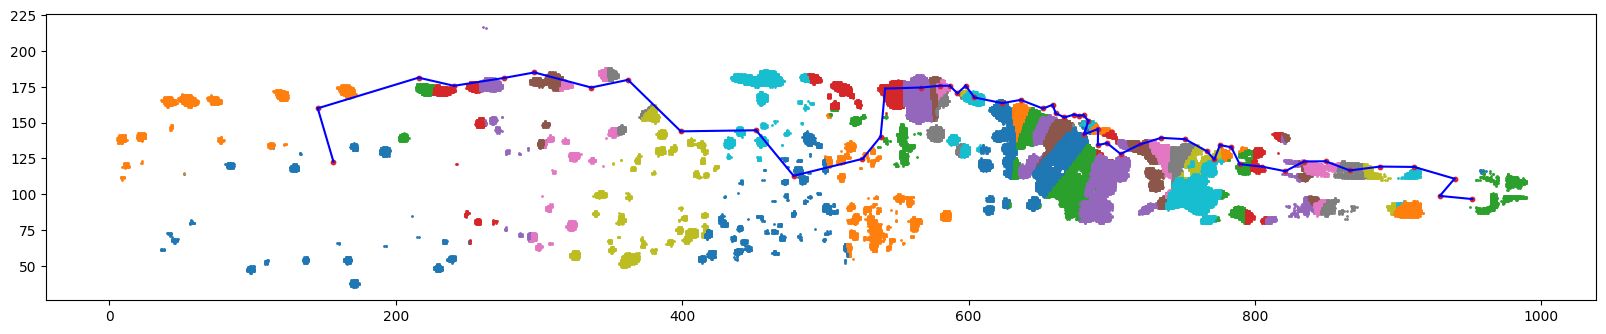

/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


26.296957052224453


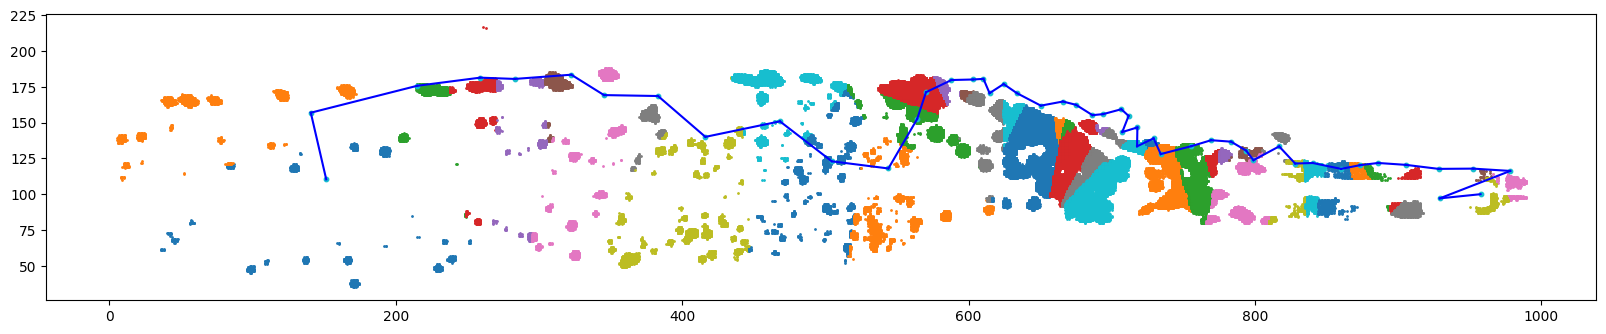

/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


26.39765531651606


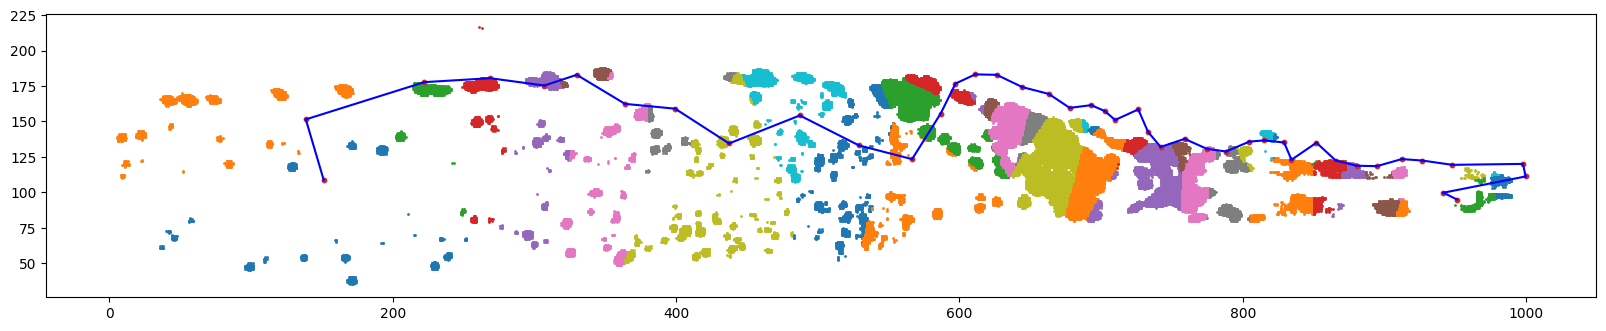

/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


26.20775950307632


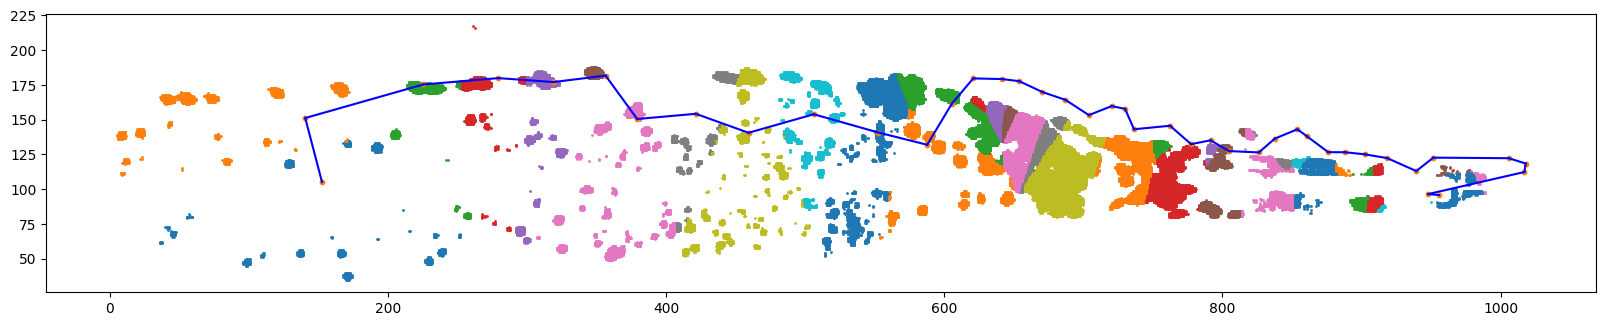

/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


26.654144360441805


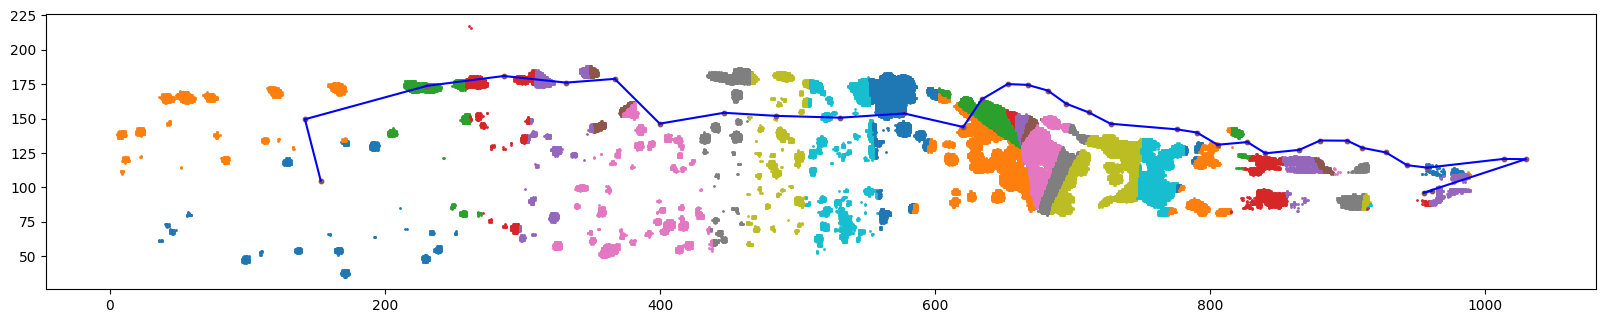

/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


27.39071406337916


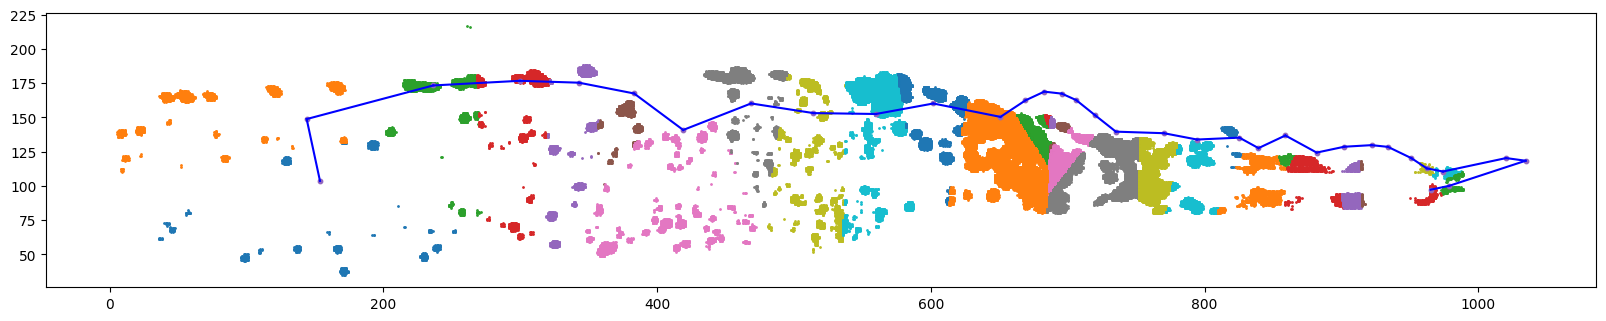

/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


27.98514458329471


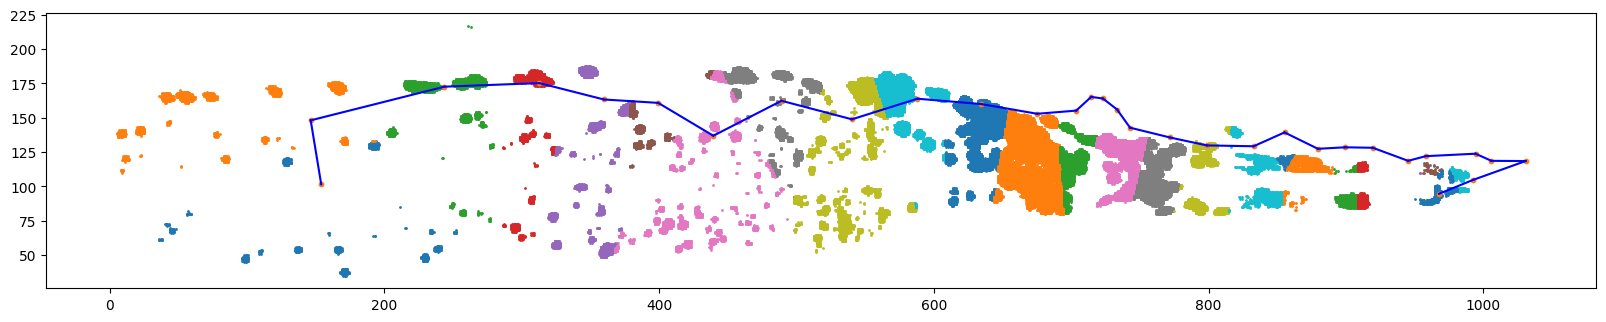

/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


26.54036611654368


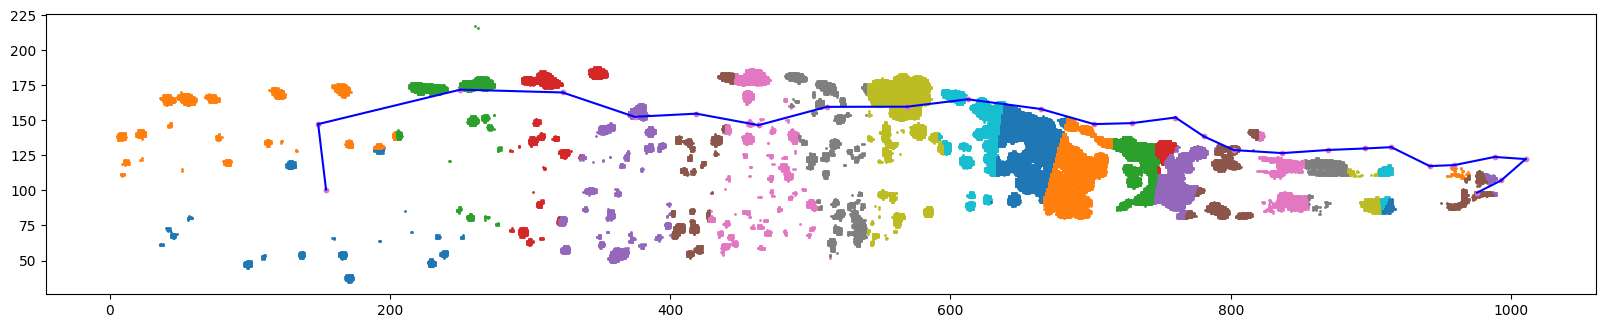

26.611517108559102


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


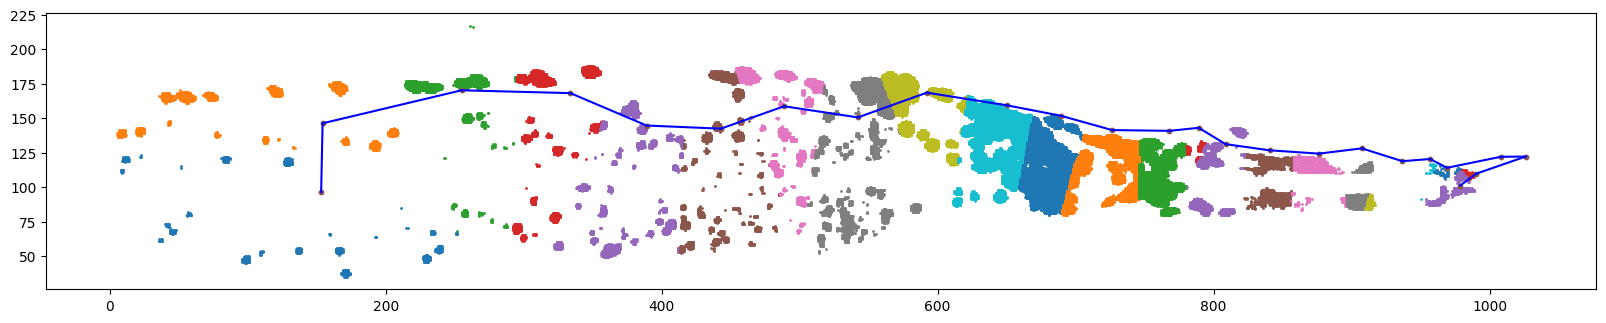

26.282180600710124


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


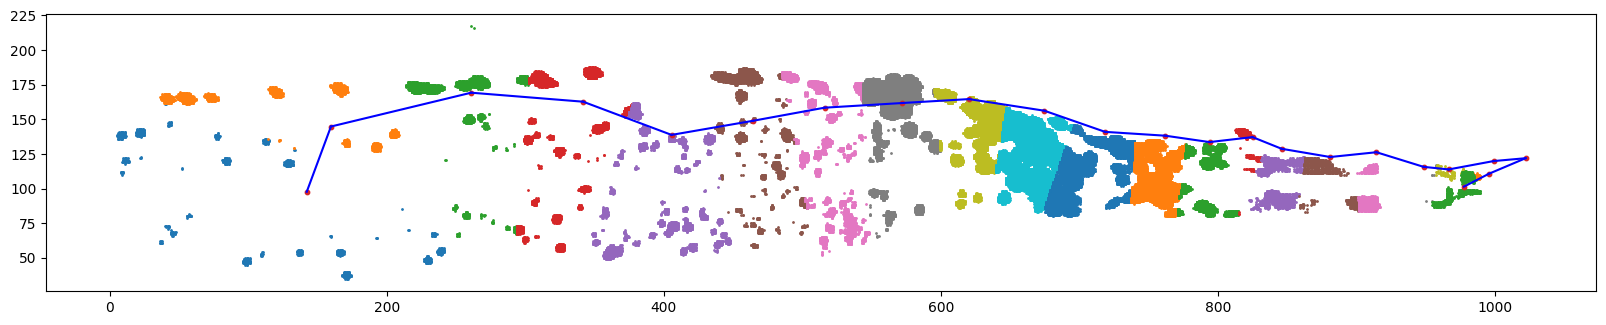

In [233]:
%matplotlib inline

for i in range(10):
    if i ==0:
        new_control, difference = update_control_points(ordered_control, voronoi, alpha=1, beta=0.5, gamma=0.2)
        print(difference)
    else:
        new_control, difference = update_control_points(new_control, new_voronoi, alpha=1, beta=0.5, gamma=0.2)
        print(difference)
    new_voronoi = calc_voronoi_region(W, new_control)

In [ ]:
def visualize_centerline(ordered_control, blobs):
    '''
    Display the calculated centerline of the worm overlayed on the point cloud of the 
    neuron locations. Projections in both XY and XZ planes (eventually make DV and LR planes)
    Display spline calculated from control points
    Input:
    Ordered list of control points
    Blobs - XYZ locations of neuron centers (derived separately from here)
    '''

    

### PCA to identify principal axes

In [6]:
from sklearn.decomposition import PCA
import pandas as pd

blobs = pd.read_csv('/Users/danielysprague/foco_lab/data/NP_FOCO_cropped/2022-04-01-w00-NP1/blobs.csv')

p_cloud = np.asarray(blobs[['X', 'Y', 'Z']])


In [149]:
def pca(p_cloud, n):

    mean = p_cloud - np.mean(p_cloud, axis=0)

    cov_mat = np.cov(mean, rowvar=False)
    evals, evects = np.linalg.eigh(cov_mat)

    sorted_index = np.argsort(evals)[::-1]

    sorted_eval = evals[sorted_index]
    sorted_evects = evects[:,sorted_index]

    PCA_vects = sorted_evects[:,0:n]
    PCA_vals = sorted_evals[0:n]

    new_cloud = np.dot(PCA_vects.transpose(), mean.transpose()).transpose()

    return new_cloud, PCA_vals, PCA_vects


In [8]:
def visualize_PCAs(folder):

    for file in os.listdir(folder):
        if file[-4:] =='.tif':
            imfile = folder + '/'+file

        elif file[-4:] == '.mat' and file[-6:]!= 'ID.mat':
            matfile = folder + '/'+file

        elif file == 'blobs.csv':
            blobs_csv = folder +'/'+file

    blobs = pd.read_csv(blobs_csv)

    p_cloud = np.asarray(blobs[['X', 'Y', 'Z']])

    data = np.transpose(skio.imread(imfile))
    RGB = data[:,:,:,[0,2,4]]

    Zmax = np.max(RGB, axis=2)
    Ymax = np.max(RGB, axis=1)

    print(RGB.shape)
    print(Zmax.shape)

    X_trans, pcvals, pcvects = PCA(p_cloud, 3)

    PC1 = pcvects[0]
    val1 = pcvals[0]
    PC2 = pcvects[1]
    val2 = pcvals[1]
    PC3 = pcvects[2]
    val3 = pcvals[2]

    blob_mean = np.mean(p_cloud, axis=0)

    maxs = np.max(p_cloud, axis=0)
    mins = np.min(p_cloud, axis=0)

    xrange = (mins[0]-5, maxs[0]+5)
    yrange = (mins[1]-5, maxs[1]+5)
    zrange = (mins[2]-5, maxs[2]+5)

    fig, axs = plt.subplots(3,2)

    axs[0, 0].scatter(p_cloud[:,0], p_cloud[:,1])
    axs[0, 0].plot([blob_mean[0]-PC1[0]*val1, blob_mean[0]-PC1[0]*-val1,blob_mean[0]], [blob_mean[1]-PC1[1]*val1, blob_mean[1]-PC1[1]*-val1,blob_mean[1]], linestyle="-", color='blue')
    axs[0, 0].plot([blob_mean[0]-PC2[0]*val2, blob_mean[0]-PC2[0]*-val2,blob_mean[0]], [blob_mean[1]-PC2[1]*val2, blob_mean[1]-PC2[1]*-val2,blob_mean[1]], linestyle="-", color='blue')
    axs[0, 0].set_xlim(xrange)
    axs[0, 0].set_ylim(yrange)
    axs[0, 0].set_xlabel('X distance in pixels')
    axs[0, 0].set_ylabel('Y distance in pixels')
    axs[0, 0].set_aspect('equal')

    axs[0, 1].scatter(p_cloud[:,0], p_cloud[:,2])
    axs[0, 1].plot([blob_mean[0]-PC1[0]*val1, blob_mean[0]-PC1[0]*-val1,blob_mean[0]], [blob_mean[2]-PC1[2]*val1, blob_mean[2]-PC1[2]*-val1,blob_mean[2]], linestyle="-", color='blue')
    axs[0, 1].plot([blob_mean[0]-PC3[0]*val2, blob_mean[0]-PC3[0]*-val2,blob_mean[0]], [blob_mean[2]-PC3[2]*val3, blob_mean[2]-PC3[2]*-val3,blob_mean[2]], linestyle="-", color='blue')
    axs[0, 1].set_xlim(xrange)
    axs[0, 1].set_ylim(zrange)
    axs[0, 1].set_xlabel('X distance in pixels')
    axs[0, 1].set_ylabel('Y distance in pixels')
    axs[0, 1].set_aspect('equal')

    transmax = np.max(X_trans, axis=0)
    transmin = np.min(X_trans, axis=0)

    xranget = (transmin[0]-5, transmax[0]+5)
    yranget = (transmin[1]-5, transmax[1]+5)
    zranget = (transmin[2]-5, transmax[2]+5)

    axs[1, 0].scatter(X_trans[:,0], X_trans[:,1])
    axs[1, 0].set_xlim(xranget)
    axs[1, 0].set_ylim(yranget)
    axs[1, 0].set_xlabel('Distance along PC1')
    axs[1, 0].set_ylabel('Distance along PC2')
    axs[1, 0].set_aspect('equal')

    axs[1, 1].scatter(X_trans[:,0], X_trans[:,2])
    axs[1, 1].set_xlim(xranget)
    axs[1, 1].set_ylim(zranget)
    axs[1, 1].set_xlabel('Distance along PC1')
    axs[1, 1].set_ylabel('Distance along PC3')
    axs[1, 1].set_aspect('equal')

    axs[2, 0].imshow(np.transpose(Zmax, [1,0,2]))
    axs[2, 0].plot([blob_mean[0]-PC1[0]*val1, blob_mean[0]-PC1[0]*-val1,blob_mean[0]], [blob_mean[1]-PC1[1]*val1, blob_mean[1]-PC1[1]*-val1,blob_mean[1]], linestyle="-", color='blue')
    axs[2, 0].plot([blob_mean[0]-PC2[0]*val2, blob_mean[0]-PC2[0]*-val2,blob_mean[0]], [blob_mean[1]-PC2[1]*val2, blob_mean[1]-PC2[1]*-val2,blob_mean[1]], linestyle="-", color='blue')
    axs[2, 0].set_xlim((0, Zmax.shape[0]))
    axs[2, 0].set_ylim((0, Zmax.shape[1]))
    axs[2, 0].set_aspect('equal')
    
    axs[2, 1].imshow(np.transpose(Ymax, [1,0,2]))
    axs[2, 1].plot([blob_mean[0]-PC1[0]*val1, blob_mean[0]-PC1[0]*-val1,blob_mean[0]], [blob_mean[2]-PC1[2]*val1, blob_mean[2]-PC1[2]*-val1,blob_mean[2]], linestyle="-", color='blue')
    axs[2, 1].plot([blob_mean[0]-PC3[0]*val3, blob_mean[0]-PC3[0]*-val3,blob_mean[0]], [blob_mean[2]-PC3[2]*val3, blob_mean[2]-PC3[2]*-val3,blob_mean[2]], linestyle="-", color='blue')
    axs[2, 1].set_xlim((0, Ymax.shape[0]))
    axs[2, 1].set_ylim((0, Ymax.shape[1]))
    axs[2, 1].set_aspect('equal')

    plt.tight_layout()

    plt.show()
    
    

In [234]:
%matplotlib qt

visualize_PCAs('/Users/danielysprague/foco_lab/data/NP_FOCO_cropped/2022-04-01-w00-NP1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1000, 240, 45, 3)
(1000, 240, 3)


In [235]:
visualize_PCAs('/Users/danielysprague/foco_lab/data/NP_FOCO_cropped/2022-02-12-w01-NP1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1000, 240, 45, 3)
(1000, 240, 3)


(1000, 240, 45, 3)
(1000, 240, 3)


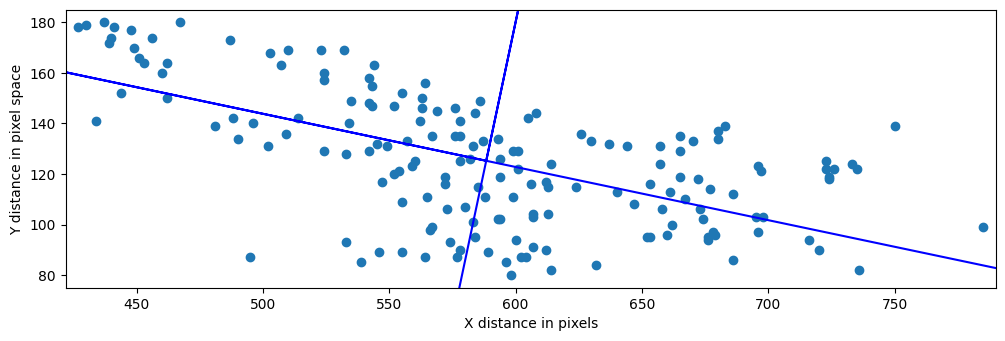

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


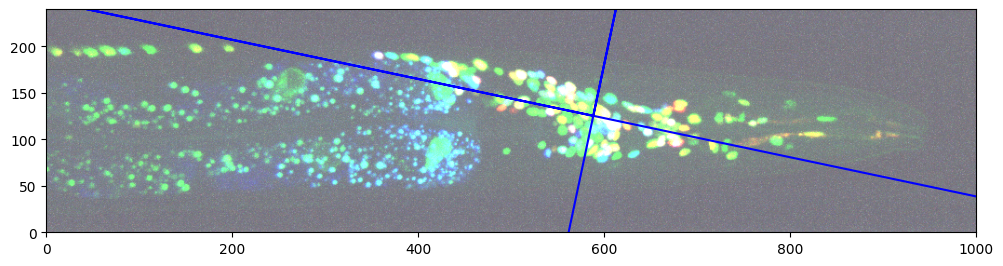

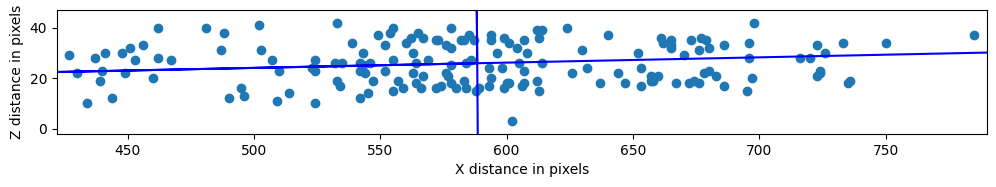

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


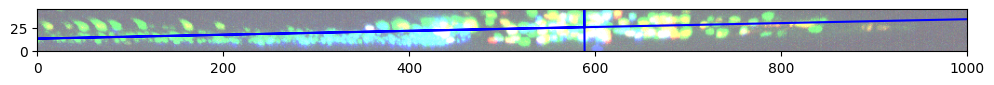

In [211]:
visualize_PCAs('/Users/danielysprague/foco_lab/data/NP_FOCO_cropped/2022-02-11-w03-NP1')

### Testing alignment


In [80]:
def pca(p_cloud, n):

    mean = p_cloud - np.mean(p_cloud, axis=0)

    cov_mat = np.cov(mean, rowvar=False)
    evals, evects = np.linalg.eigh(cov_mat)

    sorted_index = np.argsort(evals)[::-1]

    sorted_evals = evals[sorted_index]
    sorted_evects = evects[:,sorted_index]

    PCA_vects = sorted_evects[:,0:n]
    PCA_vals = sorted_evals[0:n]

    new_cloud = np.dot(PCA_vects.transpose, mean.transpose()).transpose()

    return new_cloud, PCA_vals, PCA_vects, np.asarray(np.mean(p_cloud,axis=0))


In [81]:
def transform_PCs(p, PCs, mean):

    m_p = p - mean

    vects = np.vstack(PCs)

    p_trans = np.dot(vects.transpose, m_p.transpose()).transpose()

    return p_trans

In [86]:
def get_PCs(image, blobs, PCs = None):
    '''
    Input:
    image - numpy array with dimensions (X,Y,Z,C) where C is in order RGB 
    blobs - pandas dataframe containing X,Y,Z,id columns
    scale - 3x3 diagonal matrix with the um/pixel scale for x,y,z in respective diagonal entries
    PCs - optional, use previously generated PCs

    Output:
    neuron point cloud projected into space with principal axes as basis vectors 
    '''

    ids = blobs[['ID']]
    neurons = blobs[['X','Y','Z']]
    
    if PCs is None:

        Zmax = np.max(image, axis=2)
        Ymax = np.max(image, axis=1)

        trans_blobs, pcvals, pcvects, mean = pca(neurons, 3)

        PC1 = pcvects[0]
        val1 = pcvals[0]
        PC2 = pcvects[1]
        val2 = pcvals[1]
        PC3 = pcvects[2]
        val3 = pcvals[2]

        blob_mean = np.mean(neurons, axis=0)

        plt.figure()

        plt.imshow(np.transpose(Zmax, [1,0,2]), vmin=0, vmax=255)
        plt.plot([blob_mean[0]+PC1[0]*val1, blob_mean[0]], [blob_mean[1]+PC1[1]*val1, blob_mean[1]], linestyle="-", color='blue')
        plt.plot([blob_mean[0]+PC2[0]*val2, blob_mean[0]], [blob_mean[1]+PC2[1]*val2, blob_mean[1]], linestyle="-", color='red')
        plt.xlim((0, Zmax.shape[0]))
        plt.ylim((0, Zmax.shape[1]))
        plt.gca().set_aspect('equal')

        plt.show()

        plt.figure()

        plt.imshow(np.transpose(Ymax, [1,0,2]), vmin=0, vmax=255)
        plt.plot([blob_mean[0]+PC1[0]*val1, blob_mean[0]], [blob_mean[2]+PC1[2]*val1, blob_mean[2]], linestyle="-", color='blue')
        plt.plot([blob_mean[0]+PC2[0]*val2, blob_mean[0]], [blob_mean[2]+PC2[2]*val2, blob_mean[2]], linestyle="-", color='green')
        plt.xlim((0, Ymax.shape[0]))
        plt.ylim((0, Ymax.shape[1]))
        plt.gca().set_aspect('auto')

        plt.show()

        AP = input("Is the blue line pointing anteriorly or posteriorly?: please input 'A' or 'P'")

        if AP == 'P': #PC1 should point anteriorly
            PC1 = -PC1

        else:
            PC1 = PC1

        PC2input = input("Does the red line lie on the DV axis or the LR axis: please input 'DV' or 'LR")

        print(PC2input)

        if PC2input == 'DV':
            DV = input("Is the red line pointing dorsally or ventrally?: please input 'D' or 'V'")
            if DV == 'V': #PC2 should point dorsally
                PC2 = -PC2
            else:
                PC2 = PC2

            nanminus = blobs[blobs['ID'].notna()]

            Left = nanminus[nanminus['ID'].str.endswith(('L','L?'))]
            Right = nanminus[nanminus['ID'].str.endswith(('R','R?'))]

            left_b = np.asarray(Left[['X','Y','Z']])
            right_b = np.asarray(Right[['X','Y','Z']])

            trans_left = transform_PCs(left_b, (PC1, PC2, PC3), mean)
            trans_right = transform_PCs(right_b, (PC1, PC2, PC3), mean)

            Lavg = np.mean(trans_left, axis=0)[2]
            Ravg = np.mean(trans_right, axis=0)[2]

            print(Lavg)
            print(Ravg)
            
            if Lavg > Ravg: # PC3 should point right
                PC3 = -PC3

         
        
        else:
            newPC3 = PC2
            newval3 = val2
            PC2 = PC3 #PC2 is now DV
            val2 = val3
            PC3 = newPC3 #PC3 is now LR
            val3 = newval3

            plt.figure()

            plt.imshow(np.transpose(Ymax, [1,0,2]))
            plt.plot([blob_mean[0]+PC1[0]*val1, blob_mean[0]], [blob_mean[2]+PC1[2]*val1, blob_mean[2]], linestyle="-", color='blue')
            plt.plot([blob_mean[0]+PC2[0]*val2, blob_mean[0]], [blob_mean[2]+PC2[2]*val2, blob_mean[2]], linestyle="-", color='green')
            plt.xlim((0, Ymax.shape[0]))
            plt.ylim((0, Ymax.shape[1]))
            plt.gca().set_aspect('auto')

            plt.show()
            

            DV = input("Is the green line pointing dorsally or ventrally?: please input 'D' or 'V'")

            if DV == 'V': #PC3 should point dorsally
                PC2 = -PC2
            else:
                PC2 = PC2

            nanminus = blobs[blobs['ID'].notna()]

            Left = nanminus[nanminus['ID'].str.endswith(('L','L?'))]
            Right = nanminus[nanminus['ID'].str.endswith(('R','R?'))]

            left_b = np.asarray(Left[['X','Y','Z']])
            right_b = np.asarray(Right[['X','Y','Z']])

            trans_left = transform_PCs(left_b, (PC1, PC2, PC3), mean)
            trans_right = transform_PCs(right_b, (PC1, PC2, PC3), mean)

            Lavg = np.mean(trans_left, axis=0)[2]
            Ravg = np.mean(trans_right, axis=0)[2]
            
            if Lavg > Ravg: # PC2 should point right
                PC3 = -PC3

        new_PCs = np.vstack((PC1, PC2, PC3))
        neur_mean = neurons - np.mean(neurons, axis=0)
    
        new_trans_blobs = np.dot(new_PCs, neur_mean.transpose()).transpose()

    else:

        neur_mean = neurons - np.mean(neurons, axis=0)

        new_trans_blobs = np.dot(PCs, neur_mean.transpose()).transpose()

        new_PCs = PCs

    '''
    transmax = np.max(new_trans_blobs, axis=0)
    transmin = np.min(new_trans_blobs, axis=0)

    xranget = (transmin[0]-5, transmax[0]+5)
    yranget = (transmin[1]-5, transmax[1]+5)
    zranget = (transmin[2]-5, transmax[2]+5)

    fig, axs = plt.subplots(2,1)
    axs[0].scatter(new_trans_blobs[:,0], new_trans_blobs[:,1])
    axs[0].set_xlim(xranget)
    axs[0].set_ylim(yranget)
    axs[0].set_ylabel('Distance along PC2')
    axs[0].set_aspect('auto')

    axs[1].scatter(new_trans_blobs[:,0], new_trans_blobs[:,2])
    axs[1].set_xlim(xranget)
    axs[1].set_ylim(zranget)
    axs[1].set_xlabel('Distance along PC1')
    axs[1].set_ylabel('Distance along PC3')
    axs[1].set_aspect('auto')

    plt.show()
    '''

    return new_trans_blobs, ids, new_PCs



In [126]:
def proc_files(file):

    with NWBHDF5IO(file, mode='r', load_namespaces=True) as io:
        read_nwbfile = io.read()
        image = read_nwbfile.acquisition['NeuroPALImageRaw'].data[:]
        scale = read_nwbfile.acquisition['NeuroPALImageRaw'].resolution[:]
        RGBW_chan = read_nwbfile.acquisition['NeuroPALImageRaw'].RGBW_channels[:]

        seg = read_nwbfile.processing['NeuroPAL']['VolumeSegmentation'].voxel_mask[:]
    
    blobs = pd.DataFrame.from_records(seg, columns=['X', 'Y','Z','weight', 'ID'])
    blobs = blobs.rename(columns={"x":"X", "y":"Y", "z":"Z"})
    blobs = blobs.drop(['weight'], axis=1)
    blobs = blobs.replace('nan', np.nan, regex=True)

    neurons = np.asarray(blobs[['X','Y','Z']])
    neur_mean = neurons - np.mean(neurons, axis=0)

    tag = file.split('/')[-1][:-4]

    PC_CSV = '/Users/danielysprague/foco_lab/data/PCs/'+tag+'_PC.csv'

    if os.path.exists(PC_CSV):
        PCs = np.asarray(pd.read_csv(PC_CSV, usecols=[1,2,3]))
    else:
        PCs = None

    data = np.transpose(image, (3,2,0,1))/4095 #for foco images
    print(data.shape)
    #data = np.transpose(image, (1,0,2,3))/4095 # for NP images

    scale_mat = np.identity(3) 
    scale_mat[0,0] = scale[0]
    scale_mat[1,1] = scale[1]
    scale_mat[2,2] = scale[2]

    RGB_chans = RGBW_chan[:-1]

    RGB_data = data[:,:,:,RGB_chans]

    new_blobs, IDs, PCs = get_PCs(RGB_data, blobs[['X', 'Y', 'Z', 'ID']], PCs = PCs)

    if not os.path.exists(PC_CSV):
        pd.DataFrame(PCs).to_csv(PC_CSV)

    scale = np.transpose(PCs@scale_mat)

    scale_blobs = neur_mean @ scale

    transmax = np.max(scale_blobs, axis=0)
    transmin = np.min(scale_blobs, axis=0)

    xranget = (transmin[0]-5, transmax[0]+5)
    yranget = (transmin[1]-5, transmax[1]+5)
    zranget = (transmin[2]-5, transmax[2]+5)

    fig, axs = plt.subplots(2,1)
    axs[0].scatter(scale_blobs[:,0], scale_blobs[:,1])
    axs[0].set_xlim(xranget)
    axs[0].set_ylim(yranget)
    axs[0].set_ylabel('Distance along PC2')
    axs[0].set_aspect('auto')

    axs[1].scatter(scale_blobs[:,0], scale_blobs[:,2])
    axs[1].set_xlim(xranget)
    axs[1].set_ylim(zranget)
    axs[1].set_xlabel('Distance along PC1')
    axs[1].set_ylabel('Distance along PC3')
    axs[1].set_aspect('auto')

    plt.show()

    return scale_blobs, IDs


In [127]:
def proc_dataset(folders):

    neurons = {}

    for f in os.listdir(folders):
        if f == '.DS_Store':
            continue

        print(f)
        new_blobs, IDs = proc_files(folders+'/'+f)

        for i, ID in IDs.iterrows():
            if ID.isnull().all():
                continue
            elif ID[0][-1] =='?':
                ID = ID[0][:-1]
            else:
                ID = ID[0]

            xyz = new_blobs[i,:]
            if ID not in neurons.keys():
                neurons[ID] = xyz
            else:
                neurons[ID] = np.vstack((neurons[ID], xyz))

    data = []

    for ID, locs in neurons.items():
        
        if locs.ndim>1:
            N = len(locs)

            neurmean = np.mean(locs, axis=0)
            PC1mean = neurmean[0]
            PC2mean = neurmean[1]
            PC3mean = neurmean[2]

            covmat = np.cov(locs, rowvar=False)

            PC1var = covmat[0,0]
            PC2var = covmat[1,1]
            PC3var = covmat[2,2]
            PC1PC2covar = covmat[0,1]
            PC1PC3covar = covmat[0,2]
            PC2PC3covar = covmat[1,2]

            data.append({'ID':ID, 'Count':N, 'PC1_mean':PC1mean, 'PC2_mean':PC2mean, 'PC3_mean':PC3mean, 'PC1_var':PC1var, 'PC2_var':PC2var, 'PC3_var':PC3var, 'PC1_2_covar':PC1PC2covar, 'PC1_3_covar':PC1PC3covar, 'PC2_3_covar':PC2PC3covar})


    neur_summary = pd.DataFrame(data)

    return neurons, neur_summary

20190928_08.nwb
(5, 21, 256, 512)


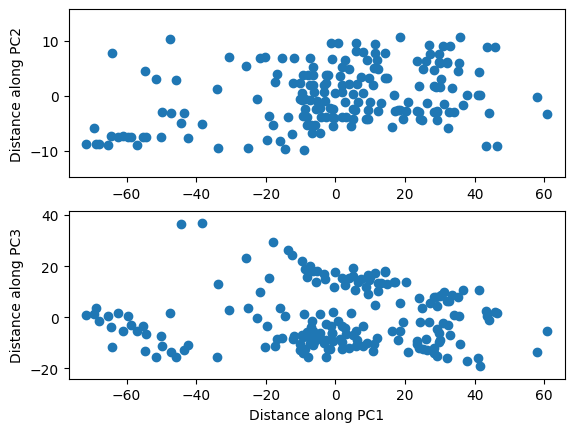

20190929_02.nwb
(5, 21, 256, 512)


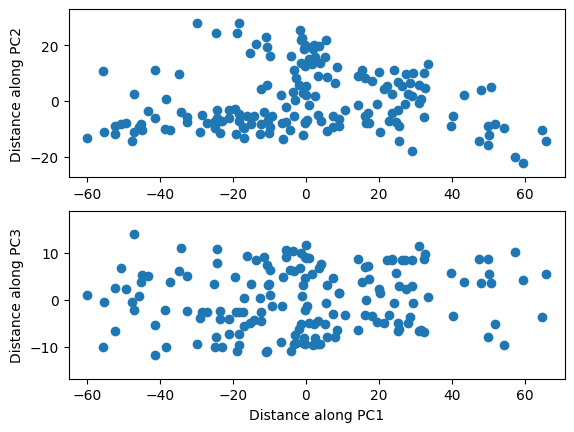

20190929_03.nwb
(5, 21, 256, 512)


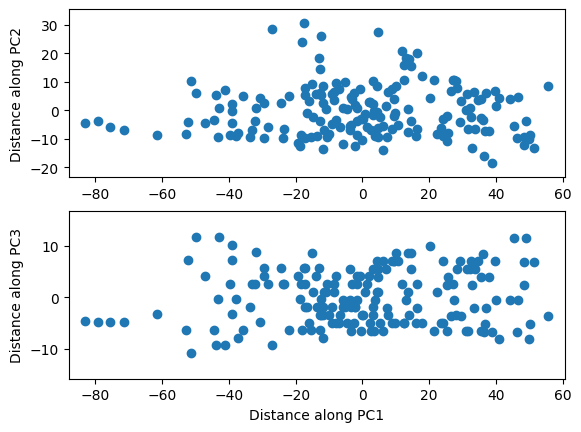

20190925_01.nwb
(5, 21, 256, 512)


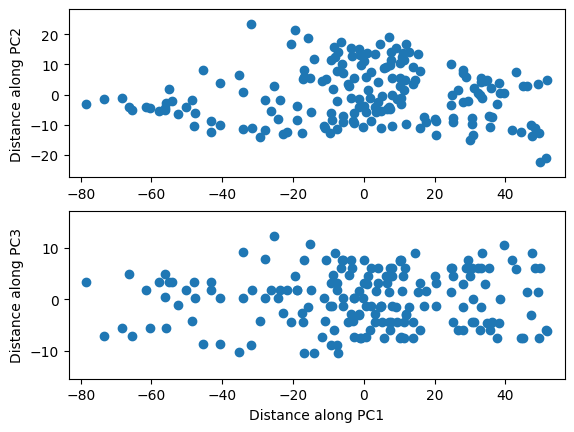

20191030_07.nwb
(5, 21, 256, 512)


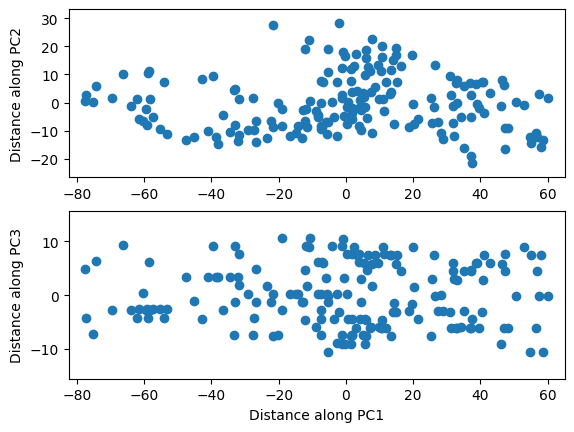

20190925_04.nwb
(5, 21, 256, 512)


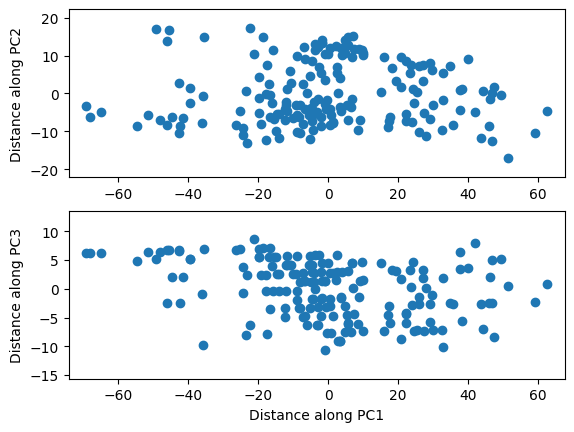

20191030_03.nwb
(5, 21, 256, 512)


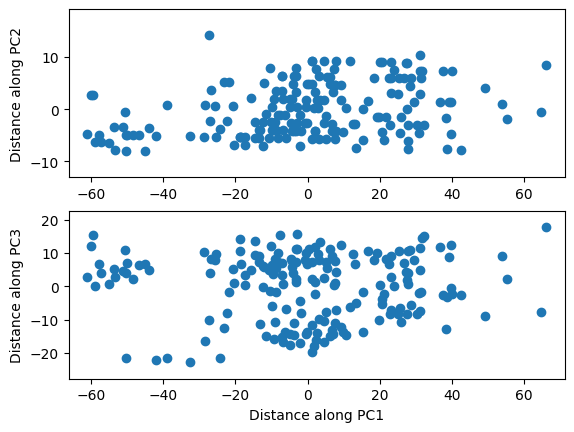

20190929_05.nwb
(5, 21, 256, 512)


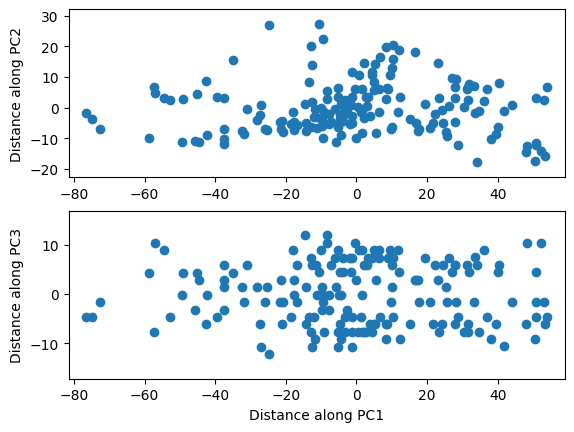

20190929_07.nwb
(5, 21, 256, 512)


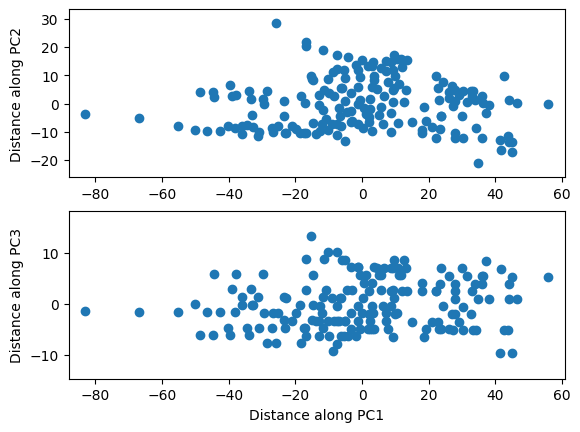

20190929_06.nwb
(5, 21, 256, 512)


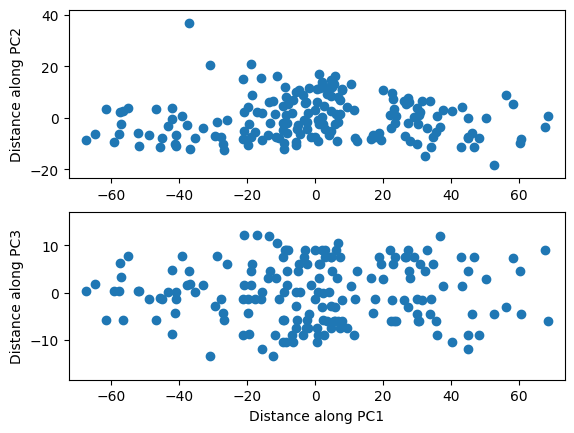

20191104_10.nwb
(5, 21, 256, 512)


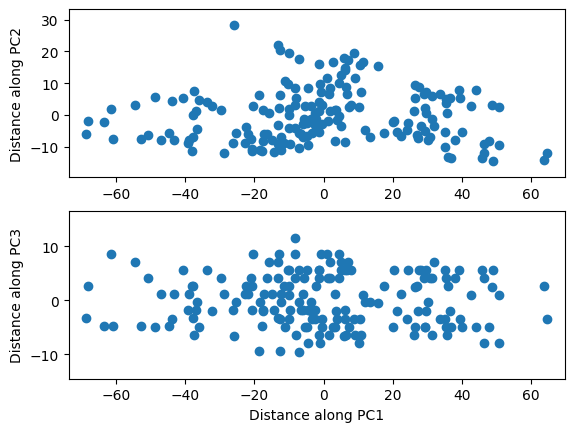

20191104_08.nwb
(5, 21, 256, 512)


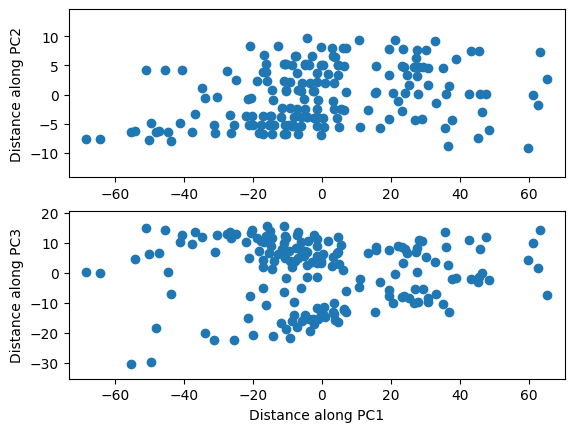

20190924_01.nwb
(5, 21, 256, 512)


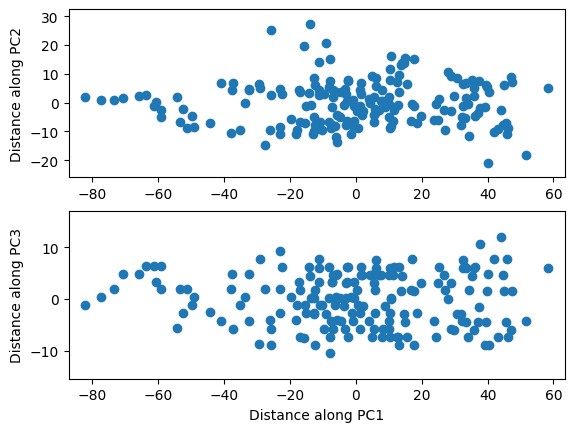

20190928_01.nwb
(5, 21, 256, 512)


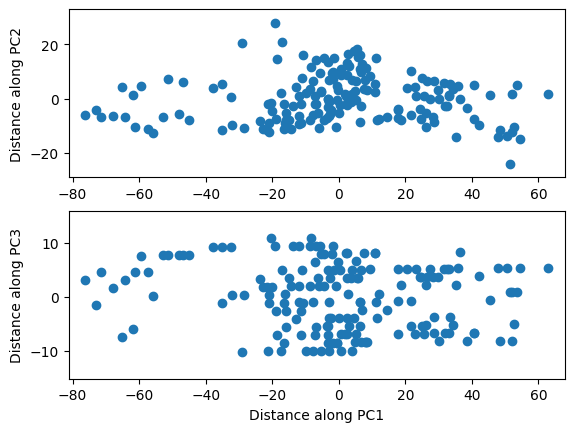

20190928_03.nwb
(5, 21, 256, 512)


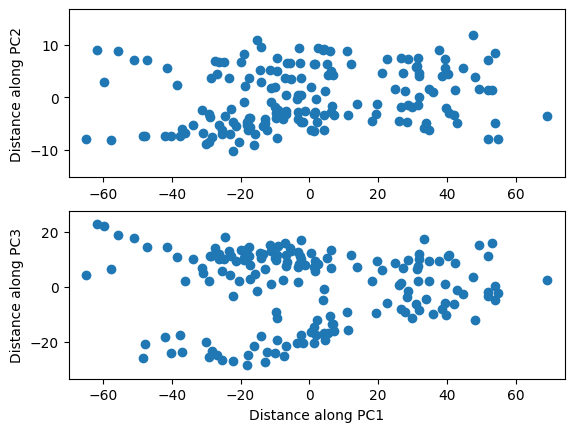

20190924_03.nwb
(5, 21, 256, 512)


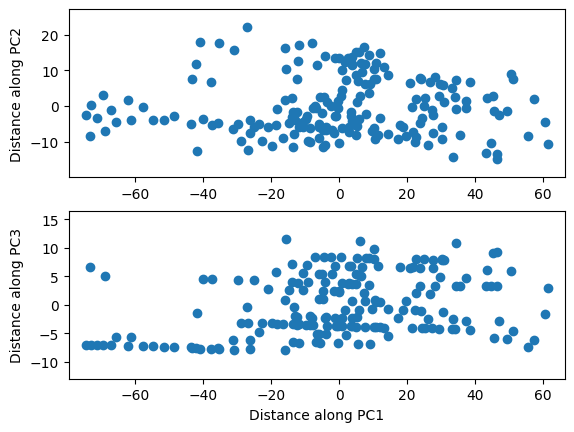

20190924_02.nwb
(5, 21, 256, 512)


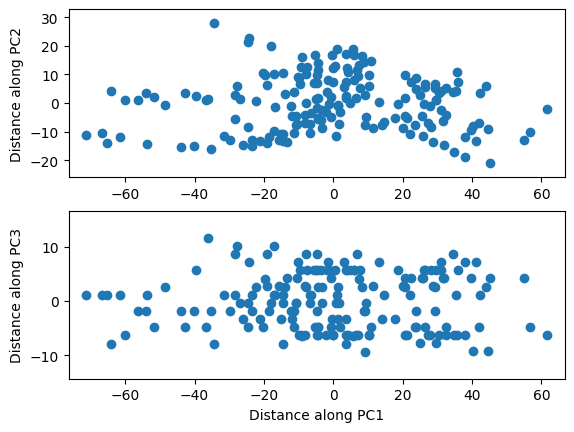

20190928_13.nwb
(5, 21, 256, 512)


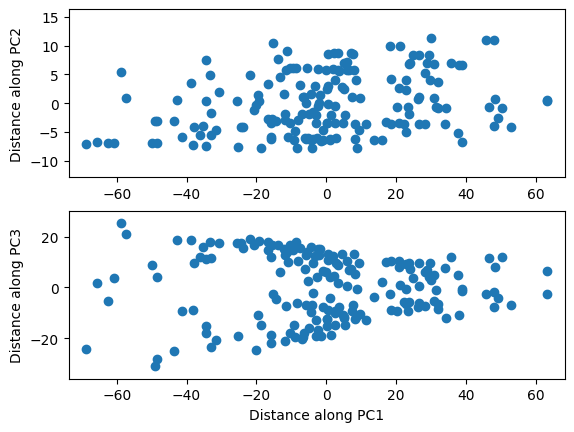

20190928_07.nwb
(5, 21, 256, 512)


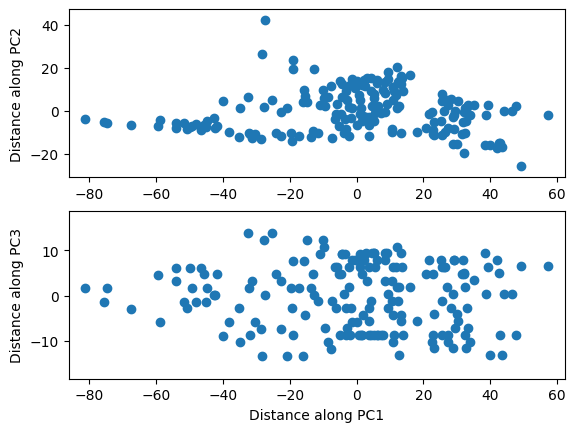

20190928_11.nwb
(5, 21, 256, 512)


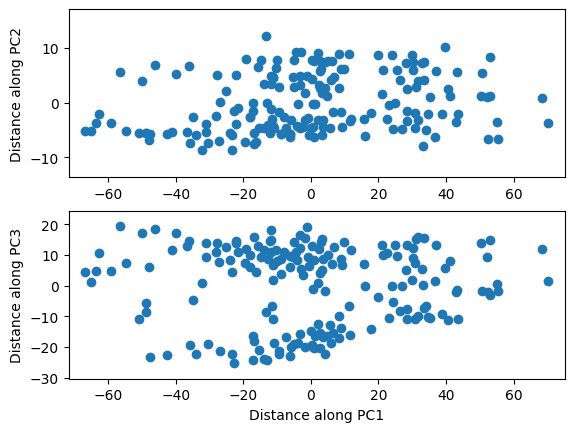

20190928_05.nwb
(5, 21, 256, 512)


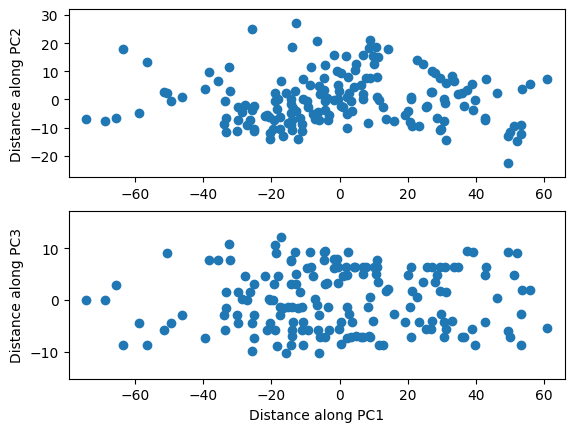

In [128]:
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume
neuron_NP, neur_summary_NP = proc_dataset('/Users/danielysprague/foco_lab/data/Yemini_NWB')

2021-12-03-w00-NP1.nwb
(1000, 240, 41, 6)


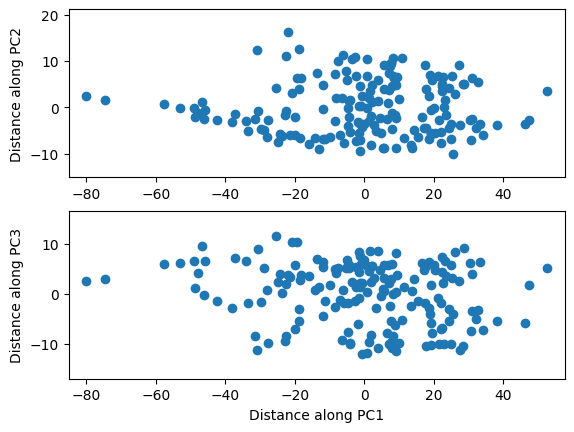

2022-03-05-w00-NP1.nwb
(1000, 240, 45, 6)


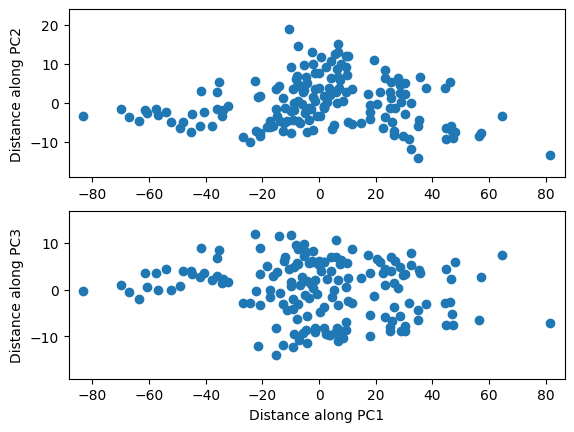

2022-02-12-w00-NP1.nwb
(1000, 240, 45, 6)


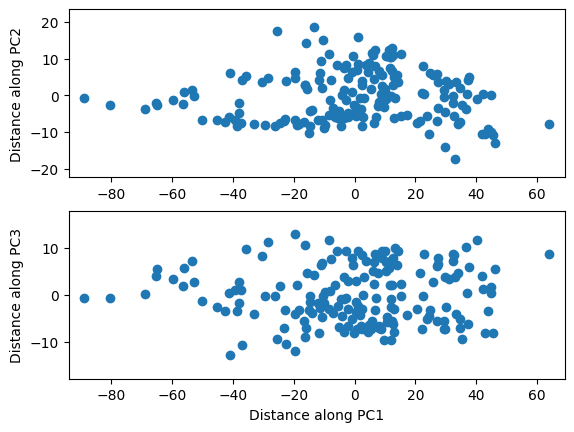

2022-02-22-w04-NP1.nwb
(1000, 240, 45, 6)


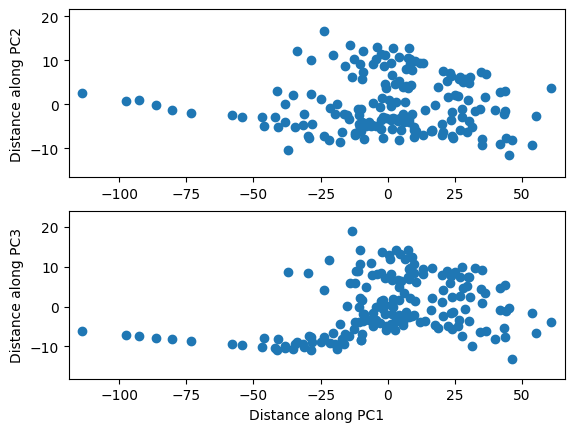

2022-02-11-w03-NP1.nwb
(1000, 240, 45, 6)


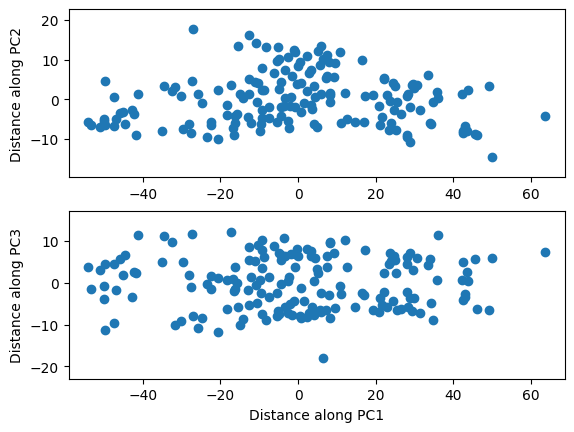

2022-02-12-w01-NP1.nwb
(1000, 240, 45, 6)


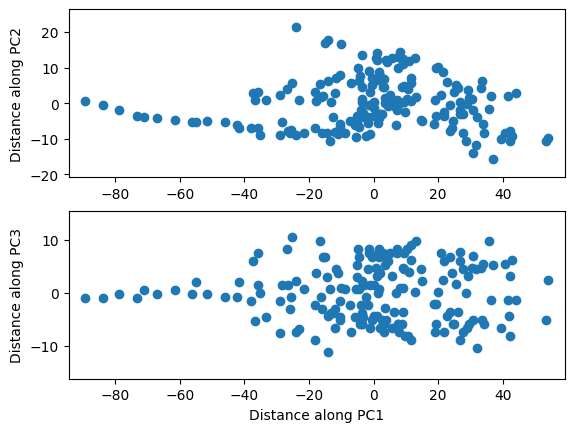

2022-01-22-w04-NP1.nwb
(1000, 240, 41, 6)


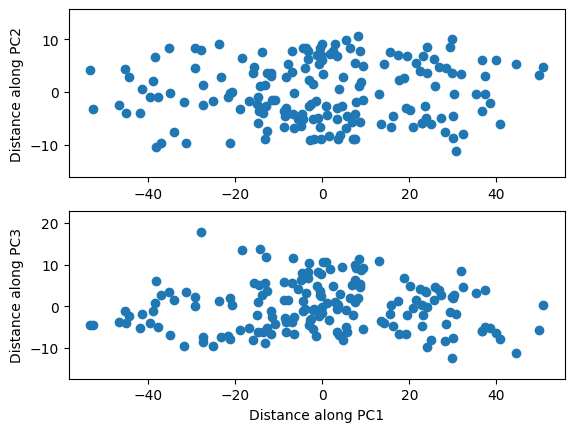

2022-04-26-w01-NP1.nwb
(1000, 240, 45, 9)


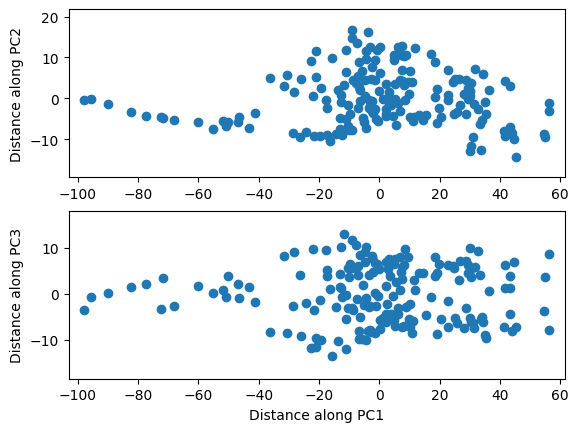

2022-04-26-w00-NP1.nwb
(1000, 240, 45, 6)


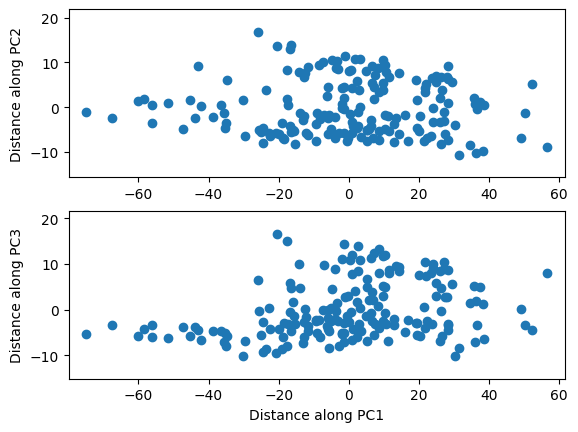

2022-04-01-w00-NP1.nwb
(1000, 240, 45, 6)


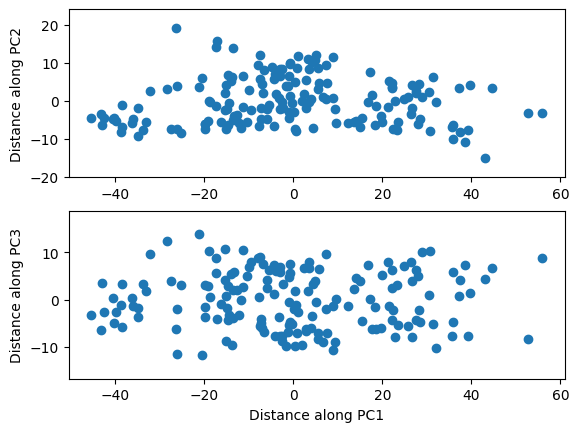

In [129]:
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume
neurons, neur_summary = proc_dataset('/Users/danielysprague/foco_lab/data/nwb')

       X    Y   Z    ID
0     19  101  11   I1R
1     23  134  13   I1L
2     77   86   7   I2R
3     79  167  13   I2L
4     80   87  19    MI
..   ...  ...  ..   ...
178  486  180   6   DD1
179  494  189   6   VD1
180  501  181   8  RIGR
181  501  171   6   AVG
182  509  184   6   VA1

[183 rows x 4 columns]
[588.36904762 125.22619048  25.89285714]
[-0.97710621 -0.21213735  0.01616149]
[-0.21228406  0.97717559 -0.00795944]
[0.01410412 0.01120804 0.99983771]


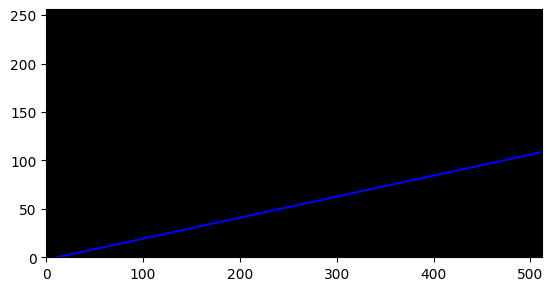

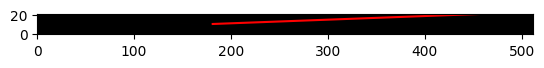

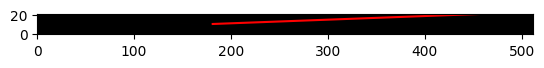

UnboundLocalError: cannot access local variable 'DV' where it is not associated with a value

In [136]:
from matplotlib.patches import Ellipse

def covar_to_coord(covar):
    #covar should be 2x2 covariance matrix
    #compute eigenvalues and rotation theta
    
    a = covar[0][0]
    b = covar[1][0]
    c = covar[1][1]
    
    lam1 = (a+c)/2 + np.sqrt(((a-c)/2)**2+b**2)
    lam2 = (a+c)/2 - np.sqrt(((a-c)/2)**2+b**2)
    
    if (b==0):
        if a>=c:
            theta =0
        else:
            theta = np.pi/2
        
    else:
        theta = np.arctan2(lam1-a, b)
        
    return np.sqrt(lam1), np.sqrt(lam2), theta

def plot_2d_neurons(neurons):


    fig = plt.figure(figsize=(15,6))
    ax = [plt.subplot(211)]
    ax.append(plt.subplot(212, sharex=ax[0]))

    #ax[0].plot(df_atlas['X'], df_atlas['Z'], 'o', mec='grey', ms=15)
    for i, row in neurons.iterrows():

        if row['Count']>3:

            xyz_sigma = np.zeros((3,3))
            xyz_sigma[0,0] = row['PC1_var']
            xyz_sigma[1,1] = row['PC2_var']
            xyz_sigma[2,2] = row['PC3_var']
            xyz_sigma[0,1] = row['PC1_2_covar']
            xyz_sigma[1,0] = row['PC1_2_covar']
            xyz_sigma[0,2] = row['PC1_3_covar']
            xyz_sigma[2,0] = row['PC1_3_covar']
            xyz_sigma[1,2] = row['PC2_3_covar']
            xyz_sigma[2,1] = row['PC2_3_covar']

            xzl1, xzl2, xztheta = covar_to_coord(xyz_sigma[[0,2],:][:,[0,2]]) 
            xyl1, xyl2, xytheta = covar_to_coord(xyz_sigma[[0,1],:][:,[0,1]])

            xz_ellipse = Ellipse((row['PC1_mean'], row['PC2_mean']), width = xzl1*2, height=xzl2*2, angle=xztheta*180/np.pi, alpha=0.2, edgecolor = 'blue', facecolor='blue', linestyle='-')
            xy_ellipse = Ellipse((row['PC1_mean'], row['PC3_mean']), width = xyl1*2, height=xyl2*2, angle=xytheta*180/np.pi, alpha=0.2, edgecolor = 'blue', facecolor='blue', linestyle='-')
            ax[0].add_patch(xz_ellipse)
            ax[1].add_patch(xy_ellipse)
  
  
    #ax[0].set_aspect('equal')
    ax[0].grid()
    ax[0].set_ylabel('PC2')
    ax[0].autoscale_view()

    #ax[1].set_aspect('equal')
    ax[1].grid()
    ax[1].set_xlabel('PC1')
    ax[1].set_ylabel('PC3')
    ax[1].autoscale_view()

    ax[0].set_title('Variances of labeled neurons in aligned PC dimension')

    #plt.tight_layout()
    plt.show()



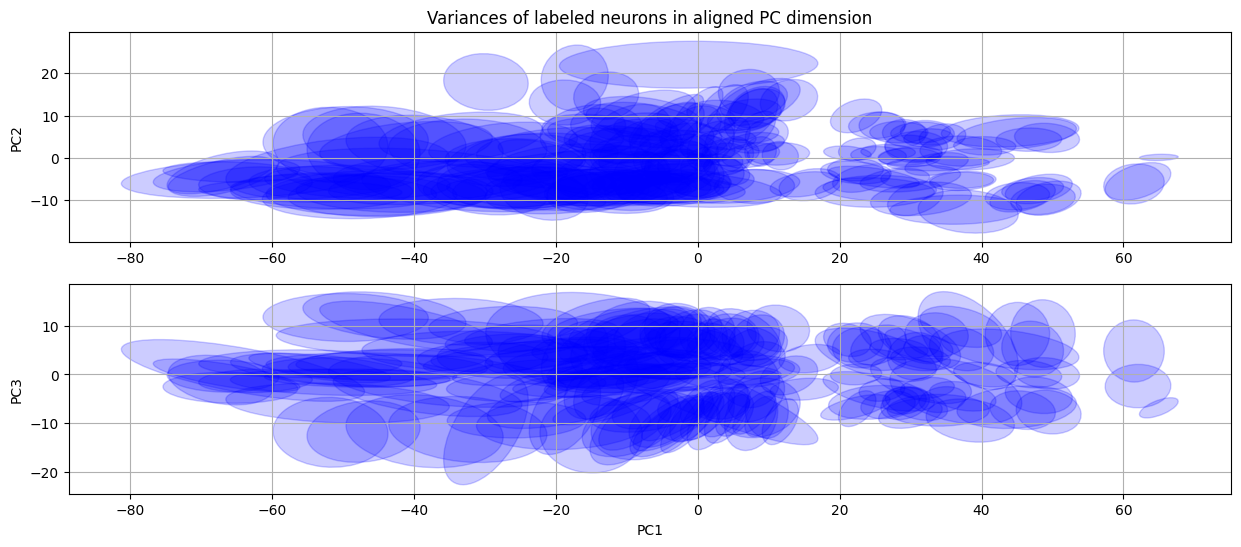

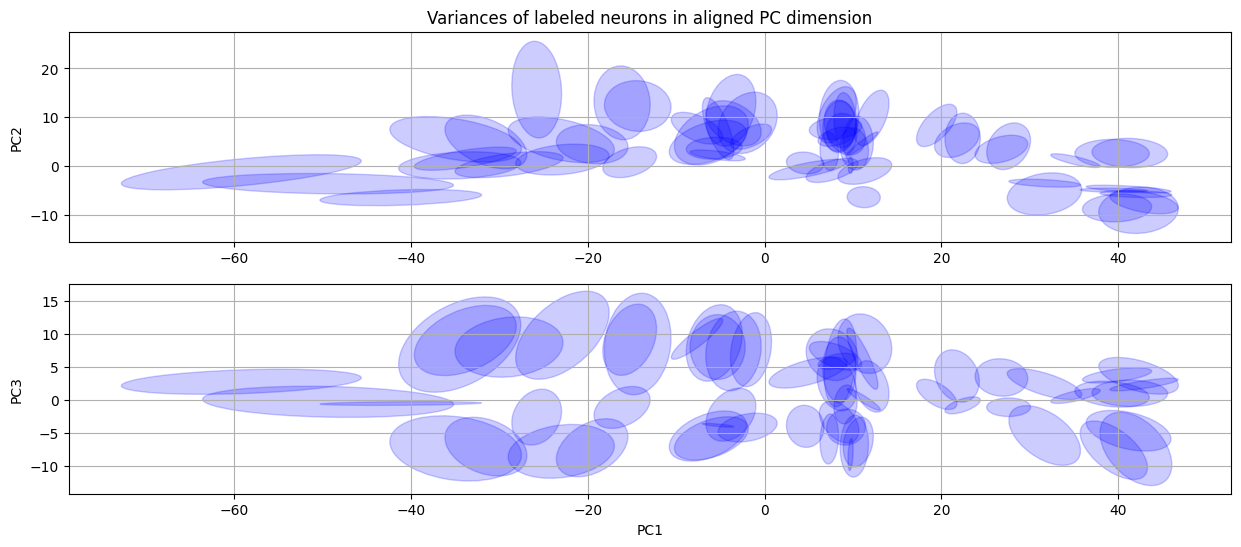

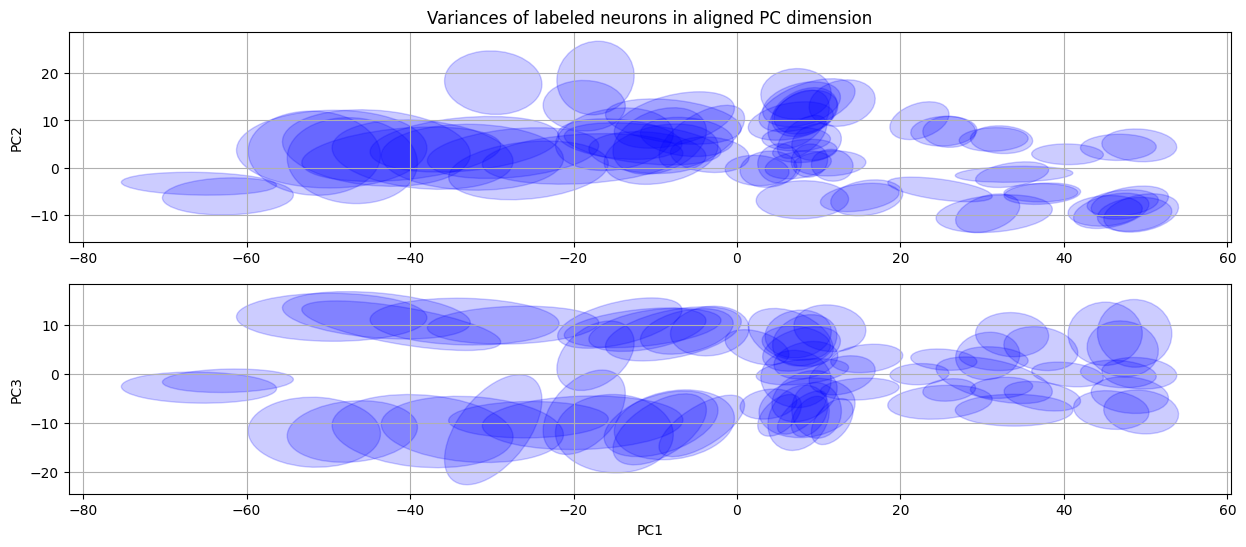

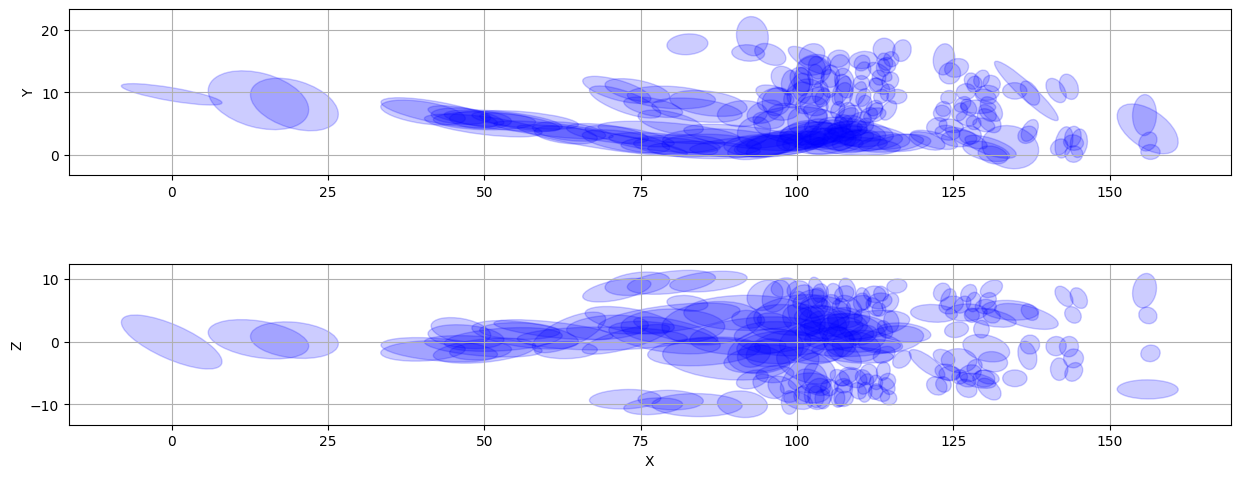

In [169]:
def plot_atlas_2d_views(mu, sigma):

    mu = sio.loadmat(mu)['mu']
    sigma = sio.loadmat(sigma)['sigma']

    mu_max = np.max(mu, axis=0)

    xyz_sigma = sigma[0:3, 0:3,:]

    fig = plt.figure(figsize=(15,6))
    ax = [plt.subplot(211)]
    ax.append(plt.subplot(212, sharex=ax[0]))

    #ax[0].plot(df_atlas['X'], df_atlas['Z'], 'o', mec='grey', ms=15)
    for i in range(mu.shape[0]):
        xzl1, xzl2, xztheta = covar_to_coord(xyz_sigma[[0,2],:,i][:,[0,2]]) 
        xyl1, xyl2, xytheta = covar_to_coord(xyz_sigma[[0,1],:,i][:,[0,1]])

        xz_ellipse = Ellipse((mu_max[0]-mu[i,0], mu_max[2]-mu[i,2]), width = xzl1*2, height=xzl2*2, angle=xztheta*180/np.pi, alpha=0.2, edgecolor = 'blue', facecolor='blue', linestyle='-')
        xy_ellipse = Ellipse((mu_max[0]-mu[i,0], mu[i,1]), width = xyl1*2, height=xyl2*2, angle=xytheta*180/np.pi, alpha=0.2, edgecolor = 'blue', facecolor='blue', linestyle='-')
        ax[0].add_patch(xz_ellipse)
        ax[1].add_patch(xy_ellipse)
  
    ax[0].set_aspect('equal')
    ax[0].grid()
    ax[0].set_ylabel('Y')
    ax[0].autoscale_view()

    ax[1].set_aspect('equal')
    ax[1].grid()
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('Z')
    ax[1].autoscale_view()

    #plt.tight_layout()
    plt.show()
plot_2d_neurons(neur_summary_NP)
plot_2d_neurons(neur_summary)
plot_2d_neurons(neur_summary_NP.where(neur_summary_NP['ID'].isin(neur_summary['ID'])))
plot_atlas_2d_views('/Users/danielysprague/foco_lab/data/atlases/atlas_xx_rgb_mu.mat','/Users/danielysprague/foco_lab/data/atlases/atlas_xx_rgb_sigma.mat')

In [167]:
print(neur_summary['ID'])
print(neur_summary_NP['ID'])

0       I2L
1       I2R
2        MI
3        I3
4       M3L
      ...  
66    CEPVR
67     IL1L
68    IL1VR
69     IL1R
70       M4
Name: ID, Length: 71, dtype: object
0        I1R
1        I1L
2        I2R
3        I2L
4         MI
       ...  
187      AS1
188      DA1
189      DB1
190    AMSOR
191    AMSOL
Name: ID, Length: 192, dtype: object


In [164]:
covs = None
NPcovs = None

for ID in neurons.keys():
        print(ID)


        if len(neurons[ID].shape)>1:
                neurmean = np.mean(neurons[ID], axis=0)
                covmat = np.cov(neurons[ID], rowvar=False)

                NPmean = np.mean(neuron_NP[ID], axis=0)
                NPcovmat = np.cov(neuron_NP[ID], rowvar=False)

                print(neurons[ID])
                print(neuron_NP[ID])
                print(covmat.diagonal())
                print(NPcovmat.diagonal())
                if covs is None:
                        covs = covmat.diagonal()
                        NPcovs = NPcovmat.diagonal()
                else:
                        covs = np.vstack((covs, covmat.diagonal()))
                        NPcovs = np.vstack((NPcovs, NPcovmat.diagonal()))

print(np.mean(covs, axis=0))
print(np.mean(NPcovs, axis=0))



I2L
[[ 34.13368808  -6.07679569  -7.24492052]
 [ 47.09397637  -9.03868437  -7.55551611]
 [ 45.40462489 -10.83861945  -8.09616543]
 [ 43.56035644  -1.62325739  -7.56445321]
 [ 46.11273612  -9.07491782  -6.32945374]
 [ 42.17611609 -10.51787856  -8.14027626]
 [ 39.8936032    6.0705646   -6.48755633]
 [ 44.12747408  -8.52338514  -8.06851656]
 [ 38.40993181   0.43693995  -6.42590738]
 [ 39.15120437  -7.74543943  -7.8139174 ]]
[[ 4.14918149e+01  5.49704008e-02 -1.90667723e+01]
 [ 5.43054326e+01 -9.62298958e+00 -9.54286632e+00]
 [ 4.98943611e+01 -1.01958678e+01 -8.14609534e+00]
 [ 4.95358465e+01 -1.29237853e+01 -7.46240380e+00]
 [ 5.86805958e+01 -1.33633214e+01 -1.05036813e+01]
 [ 4.68935474e+01 -1.25371115e+01 -2.52659039e+00]
 [ 4.24390491e+01 -7.76752942e+00 -2.65040231e+00]
 [ 5.05225295e+01 -1.74696712e+01 -9.08650405e+00]
 [ 4.51206025e+01 -1.34869379e+01 -9.67926793e+00]
 [ 4.80663583e+01 -7.92013475e+00 -8.98393029e+00]
 [ 5.06861828e+01 -9.48976015e+00 -7.91254480e+00]
 [ 4.84256187e

In [147]:
print(neurons['I2L'])

[[ 34.13368808  -6.07679569  -7.24492052]
 [ 47.09397637  -9.03868437  -7.55551611]
 [ 45.40462489 -10.83861945  -8.09616543]
 [ 43.56035644  -1.62325739  -7.56445321]
 [ 46.11273612  -9.07491782  -6.32945374]
 [ 42.17611609 -10.51787856  -8.14027626]
 [ 39.8936032    6.0705646   -6.48755633]
 [ 44.12747408  -8.52338514  -8.06851656]
 [ 38.40993181   0.43693995  -6.42590738]
 [ 39.15120437  -7.74543943  -7.8139174 ]]
